In [1]:
import os, glob, pickle
import pandas as pd
import re
import time
import itpScraper
from bs4 import BeautifulSoup
import numpy as np
import datetime

## Load User Dicts (Shown Below in 2 Pieces)

In [37]:
sessions_master_dict = {}
user_arrays = {}
errors = []
users_w_errors = []
for ud in [user_dicts_prev, user_dict]:
    user_names = list(ud.keys())
    for user in user_names:
        try:
            user_sessions = ud[user]
            #Create User Array
            u_s_ids = sorted([s['id'] for s in user_sessions])
            user_array = np.isin(all_ids, u_s_ids).astype(int)
            user_arrays[user] = user_array
            for s in user_sessions:
                #If Session Not Previously Seen Cache in Master Session Dict
                if s['id'] not in sessions_master_dict.keys():
                    sessions_master_dict['id'] = s
        except Exception as e:
            print("Hit Error: ", e)
            errors.append(e)
            users_w_errors.append(user)
print(len(sessions_master_dict.keys()))
#Create DF From Sparse User Arrays
df = pd.DataFrame.from_dict(user_arrays, orient='index')
df.columns = all_ids
print(df.shape)
df.head()
    

1
(206, 245)


,1,8,9,10,11,12,13,14,15,16,...,279,280,281,282,283,285,288,290,291,293
Abby Schmiedt,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Adeline Setiawan,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aki,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alan Wong,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
filename = "UserSessionAttendanceArrays_as_of_{}.csv".format(time_now)
print("Saving to: {}".format(filename))
df.to_csv(filename)

Saving to: UserSessionAttendanceArrays_as_of_06-12-23_2036PM.csv


In [ ]:
df_col = df.transpose()
df_col.

In [42]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(df, df)
dist.shape

(206, 206)

/Users/matthewmitchell/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


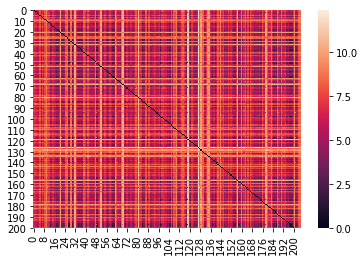

In [44]:
import seaborn as sns
sns.heatmap(dist)

In [45]:
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import metrics
from sklearn.cluster import KMeans

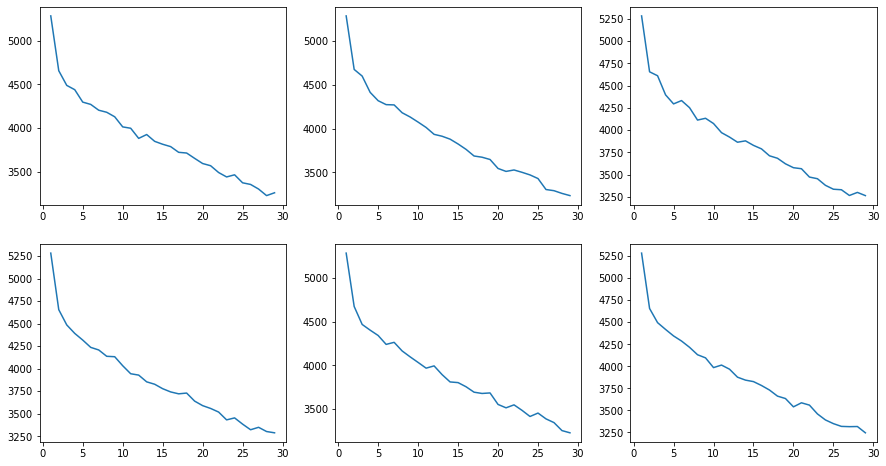

In [50]:
#This has a random seed - you can rerun with slightly different results

ncols = 2
fig, axs = plt.subplots(ncols,3, figsize=(15,8))

for n in range(6):
    cluster_inertias = []
    cluster_sizes = []


    ax = axs[n%ncols][n//ncols]
    for i in range(1,30):
        kmeans = KMeans(
            n_clusters=i,
            max_iter=100,
            n_init=1,
        ).fit(df)

        cluster_inertias.append(kmeans.inertia_)
        cluster_sizes.append(i)
    ax.plot(cluster_sizes, cluster_inertias)

In [52]:
from collections import Counter

In [62]:
kmeans = KMeans(n_clusters=15,
                max_iter=100,
                n_init=1,
                )
clusters = kmeans.fit_predict(df)
print(clusters.shape)
print(Counter(clusters))

(206,)
Counter({1: 131, 7: 43, 2: 7, 5: 5, 3: 3, 4: 3, 9: 3, 11: 2, 14: 2, 12: 2, 0: 1, 10: 1, 8: 1, 6: 1, 13: 1})


In [63]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## PCA Viz

Explained variance:  [0.17170712 0.03908406 0.03403729]


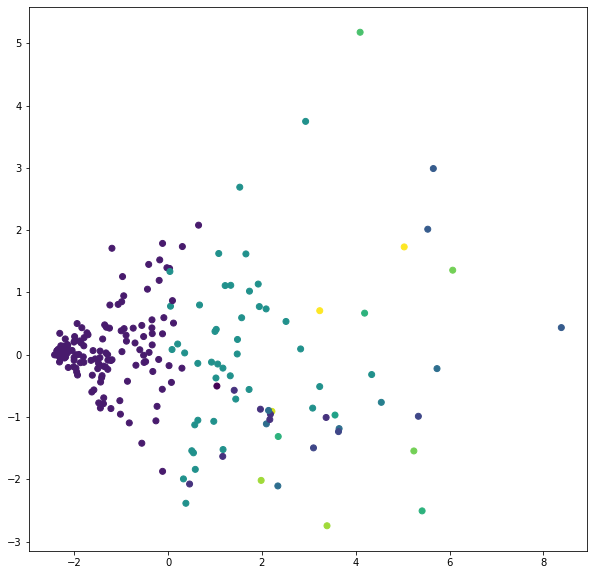

In [82]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

print("Explained variance: ",pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters)

In [83]:
from mpl_toolkits.mplot3d import Axes3D

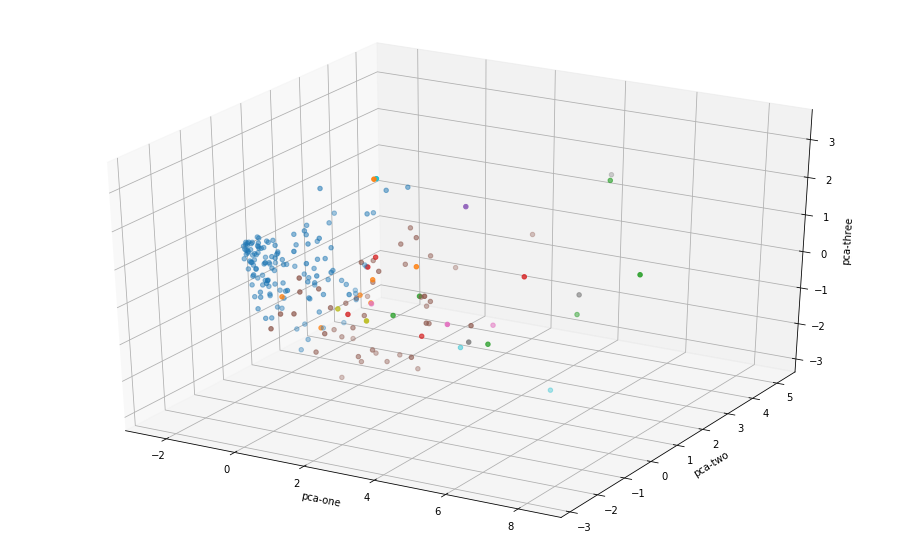

In [86]:
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=clusters, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### TSNE

In [87]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.001s...
[t-SNE] Computed neighbors for 206 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 1.722843
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.981888
[t-SNE] KL divergence after 300 iterations: 1.186101
t-SNE done! Time elapsed: 0.4562528133392334 seconds


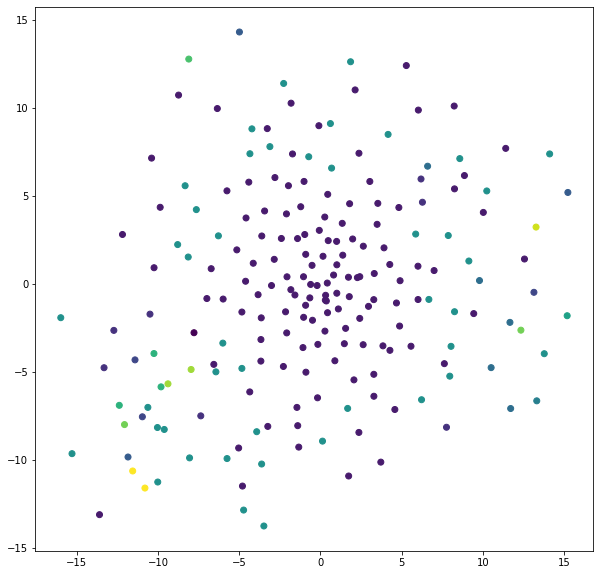

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters)

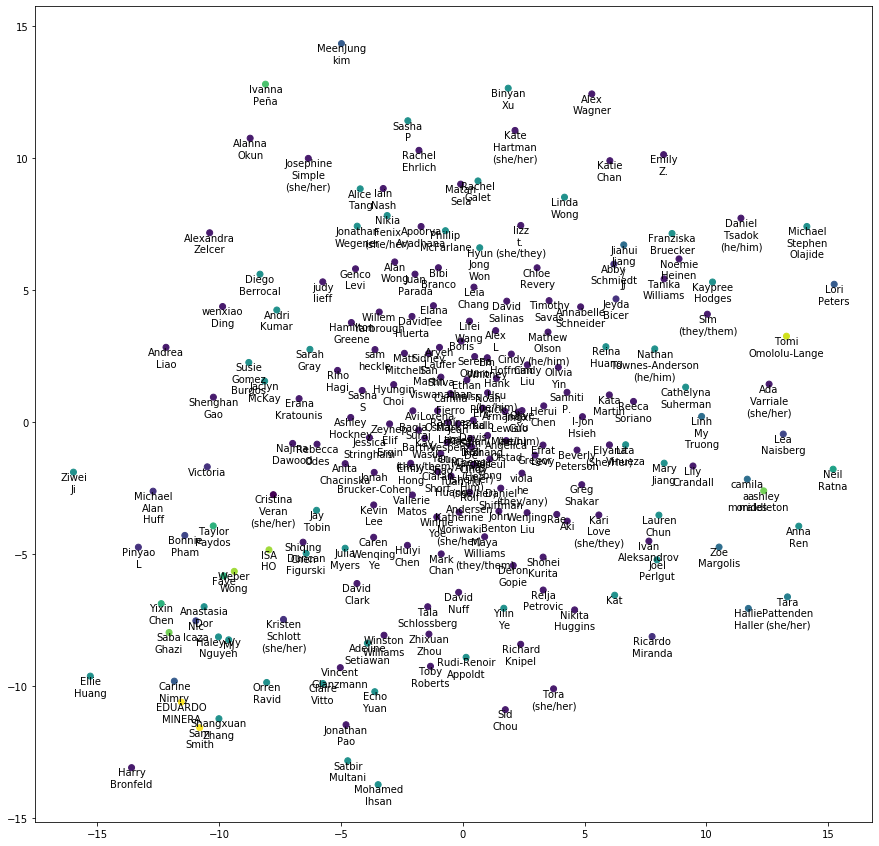

In [91]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters)

# add labels to all points
for (xi, yi, name) in zip(tsne_results[:,0], tsne_results[:,1], df.index):
    plt.text(xi, yi, "\n".join(name.split()), va='top', ha='center')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.001s...
[t-SNE] Computed neighbors for 206 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 1.722843
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.171616
[t-SNE] KL divergence after 300 iterations: 3.661182


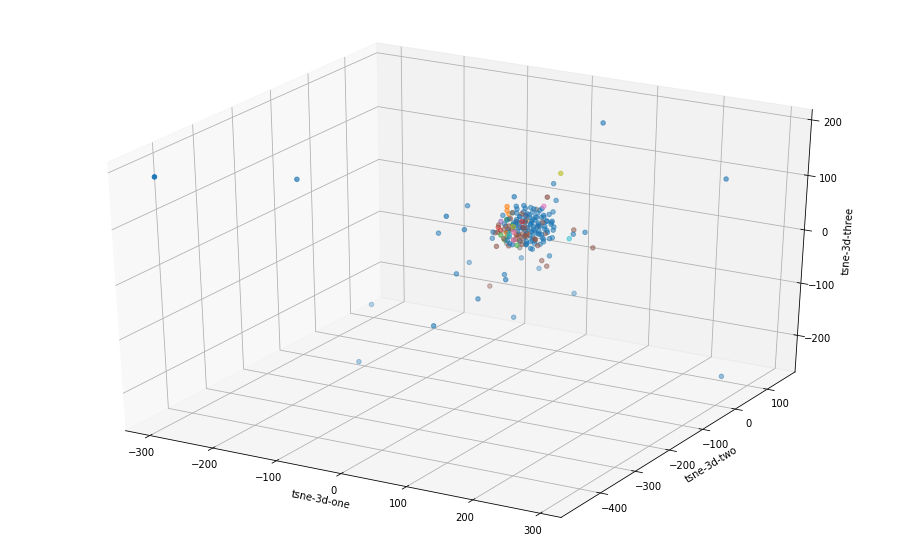

In [90]:
time_start = time.time()
tsne3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results_3d = tsne3d.fit_transform(df)

df['tsne-3d-one'] = tsne_results_3d[:,0]
df['tsne-3d-two'] = tsne_results_3d[:,1] 
df['tsne-3d-three'] = tsne_results_3d[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df['tsne-3d-one'], 
    ys=df['tsne-3d-two'], 
    zs=df['tsne-3d-three'], 
    c=clusters, 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

## User's 5 Closest Euclidean Pairs:

In [94]:
df.reset_index().head()

,index,1,8,9,10,11,12,13,14,15,...,288,290,291,293,pca-one,pca-two,pca-three,tsne-3d-one,tsne-3d-two,tsne-3d-three
0,Abby Schmiedt,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1.164394,-1.631332,-0.472374,-16.924307,37.095898,-0.441268
1,Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,...,0,0,0,0,0.114797,0.508827,-0.341567,-35.378662,1.147689,15.965610
2,Adeline Setiawan,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.051105,0.779783,-1.957770,-12.521429,-2.318404,-14.256520
3,Aki,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.249912,0.427728,0.538733,12.888682,25.711899,-24.192410
4,Alan Wong,0,0,0,1,1,0,0,1,0,...,0,0,0,0,-0.512527,-0.122902,-1.706515,-22.745930,-6.483883,-4.374103


In [98]:
ex_user = "Matt Mitchell"
temp = df.reset_index().rename(columns={'index':'Name'})
row_number = temp[temp.Name==ex_user].index
print(row_number)

Int64Index([125], dtype='int64')


In [112]:
closest_usr_indices = np.argsort(dist[row_number])[0,:10]
closest_usr_indices
closest_users = temp.loc[closest_usr_indices]['Name']
closest_users

125                           Matt Mitchell
62                             Ethan Inniss
140                                Olive Yu
30                    Camila Fierro Ramírez
61                                Eric Kalb
158     Sam De Armas\n            (she/her)
49     Dror Margalit\n            (He/ Him)
57                               Em Whitney
28                               Brad Davis
84                               Jean Haley
Name: Name, dtype: object

In [110]:
from sklearn.metrics import jaccard_score

In [124]:
cols = [col for col in df.columns if type(col)==int]
for user in closest_users:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    print("{} Jaccard Similarity: {}".format(user, score))

Matt Mitchell Jaccard Similarity: 1.0
Ethan Inniss Jaccard Similarity: 0.16666666666666666
Olive Yu Jaccard Similarity: 0.09090909090909091
Camila Fierro Ramírez Jaccard Similarity: 0.08333333333333333
Eric Kalb Jaccard Similarity: 0.08333333333333333
Sam De Armas
            (she/her) Jaccard Similarity: 0.0
Dror Margalit
            (He/ Him) Jaccard Similarity: 0.0
Em Whitney Jaccard Similarity: 0.14285714285714285
Brad Davis Jaccard Similarity: 0.0
Jean Haley Jaccard Similarity: 0.0


In [118]:
usr1_s_ids = [col for col in df.columns if df.loc[ex_user][col] == 1]
usr2_s_ids = [col for col in df.columns if df.loc[user][col] == 1]
print(usr1_s_ids)
print(usr2_s_ids)

[10, 34, 49, 64, 72, 79, 114, 130, 190, 252, 256]
[10, 34, 49, 64, 72, 79, 114, 130, 190, 252, 256]


In [128]:
similarities = []
for user in df.index:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    similarities.append((user, score))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
similarities[:10]

[('Matt Mitchell', 1.0),
 ('Kata Martin', 0.21875),
 ('Ricardo Miranda', 0.175),
 ('Erana Kratounis', 0.16666666666666666),
 ('Ethan Inniss', 0.16666666666666666),
 ('I-Jon Hsieh', 0.16666666666666666),
 ('Kevin Lee', 0.16666666666666666),
 ('Adeline Setiawan', 0.16216216216216217),
 ('Ivan Aleksandrov', 0.16216216216216217),
 ('Shohei Kurita', 0.16)]

In [142]:
ex_user = np.random.choice(df.index, 1)[0]
print("Example User: ", ex_user)

similarities = []
for user in df.index:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    similarities.append((user, score))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
similarities[:10]

Example User:  Lori Peters


[('Lori Peters', 1.0),
 ('MeenJung kim', 0.49444444444444446),
 ('Saba Ghazi', 0.45),
 ('Carine Nimry', 0.40625),
 ('EDUARDO MINERA', 0.4025157232704403),
 ('Michael Stephen Olajide', 0.375),
 ('Nic Icaza', 0.35443037974683544),
 ('ashley middleton', 0.35403726708074534),
 ('Neil Ratna', 0.3466666666666667),
 ('Anastasia Dor', 0.34459459459459457)]

In [144]:
user = similarities[1][0]

usr1_s_ids = [col for col in df.columns if df.loc[ex_user][col] == 1]
usr2_s_ids = [col for col in df.columns if df.loc[user][col] == 1]
print("{} {} sessions:\n{}".format(ex_user, len(usr1_s_ids), usr1_s_ids))
print("{} {} sessions:\n{}".format(user, len(usr2_s_ids), usr2_s_ids))

Lori Peters 120 sessions:
[1, 8, 9, 12, 13, 19, 20, 21, 22, 24, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 47, 48, 49, 50, 55, 56, 57, 58, 60, 61, 65, 67, 68, 70, 71, 72, 74, 75, 81, 82, 83, 84, 85, 86, 88, 89, 92, 94, 95, 97, 99, 100, 105, 106, 107, 109, 112, 116, 125, 126, 128, 129, 130, 137, 138, 139, 140, 141, 143, 145, 146, 147, 150, 151, 152, 153, 155, 157, 158, 159, 160, 165, 166, 169, 173, 174, 175, 176, 178, 179, 203, 227, 233, 243, 246, 247, 248, 249, 250, 253, 256, 257, 259, 261, 262, 263, 264, 265, 266, 270, 271, 272, 275, 276, 281]
MeenJung kim 149 sessions:
[1, 8, 14, 16, 17, 18, 19, 21, 22, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 113, 114, 115, 126, 127, 128, 129, 130, 133, 134, 135, 136, 137, 138, 139, 140

Sessions Per Persion Stats
Mean: 32.11 Median: 26.0


Text(0.5, 0, 'Number of Sessions Someone Signed Up For')

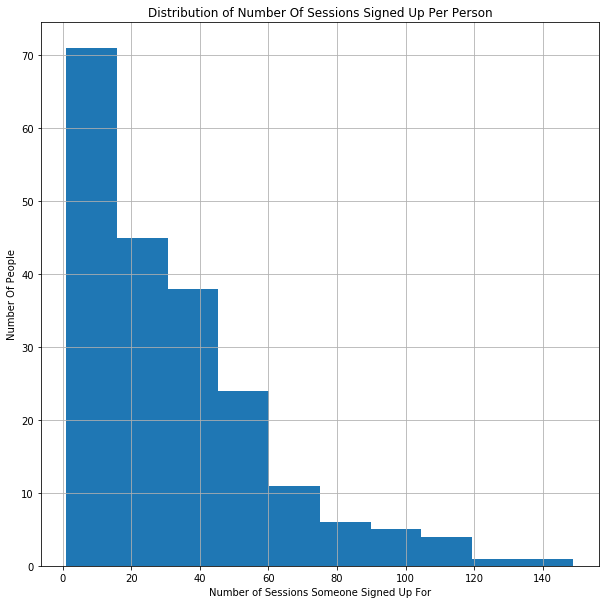

In [151]:
signups_pp = df[cols].sum(axis=1)
print("Sessions Per Persion Stats\nMean: {} Median: {}".format(round(np.mean(signups_pp),2),
                                                              round(np.median(signups_pp),2)
                                                              )
     )
signups_pp.hist(figsize=(10,10))
plt.title("Distribution of Number Of Sessions Signed Up Per Person")
plt.ylabel("Number Of People")
plt.xlabel("Number of Sessions Someone Signed Up For")